In [1]:
## forecasting trail traffic using ARMA, ARIMA
## trail data: Cheshire, Hamden, New Haven

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from datetime import date
from datetime import datetime
%matplotlib inline

C:\Users\myin9\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
In C:\Users\myin9\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\myin9\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\myin9\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\myin9\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_

In [3]:
# read data
df = pd.read_csv('trail.csv', usecols=['Date','Hamden'])

df['Date']=pd.to_datetime(df['Date'])
print(df.head())

# imputation
df['Hamden'].fillna(0,inplace=True)

df = df.set_index('Date')
df['Hamden'] = df['Hamden'].apply(pd.to_numeric, errors='ignore')

print(df.head(5))


        Date  Hamden
0 2016-11-19     NaN
1 2016-11-20     NaN
2 2016-11-21     NaN
3 2016-11-22     NaN
4 2016-11-23     NaN
            Hamden
Date              
2016-11-19     0.0
2016-11-20     0.0
2016-11-21     0.0
2016-11-22     0.0
2016-11-23     0.0


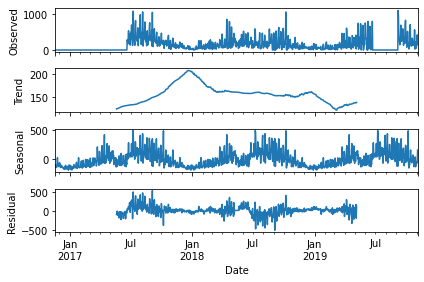

In [4]:
# return with trend, seasonal, and residual
result = sm.tsa.seasonal_decompose(df.Hamden, freq=365)
result.plot()
plt.show()

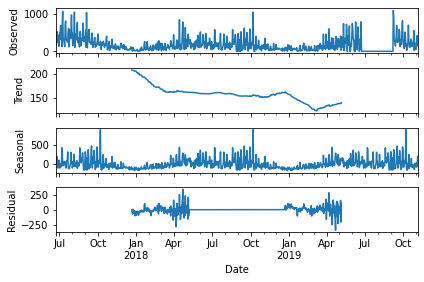

In [5]:
# drop the days before sensor installation, then see the trend again
df =df[215:]
# return with trend, seasonal, and residual
result = sm.tsa.seasonal_decompose(df.Hamden, freq=365)
result.plot()
plt.show()

## ARMA

In [6]:
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [7]:
warnings.filterwarnings('ignore')

In [8]:
df_month = df.resample('M').mean()
df_q = df.resample('Q-DEC').mean()
df_year = df.resample('A-dec').mean()
print(df_month)
#print(df_q)
#print(df_year)  #

                Hamden
Date                  
2017-06-30  293.555556
2017-07-31  441.451613
2017-08-31  391.064516
2017-09-30  289.933333
2017-10-31  180.483871
2017-11-30  122.766667
2017-12-31   61.064516
2018-01-31   66.322581
2018-02-28  111.500000
2018-03-31  130.967742
2018-04-30  228.933333
2018-05-31  207.967742
2018-06-30  227.933333
2018-07-31  190.806452
2018-08-31  184.838710
2018-09-30  240.500000
2018-10-31  158.548387
2018-11-30   92.366667
2018-12-31   66.032258
2019-01-31   53.935484
2019-02-28   66.250000
2019-03-31  110.774194
2019-04-30  209.666667
2019-05-31  265.870968
2019-06-30  239.733333
2019-07-31    0.000000
2019-08-31    0.000000
2019-09-30  334.066667
2019-10-31  213.322581
2019-11-30  269.750000


In [10]:
#print(df_q)  #11 rows
print(df_year)  #3 rows

                Hamden
Date                  
2017-12-31  250.357513
2018-12-31  158.860274
2019-12-31  150.646104


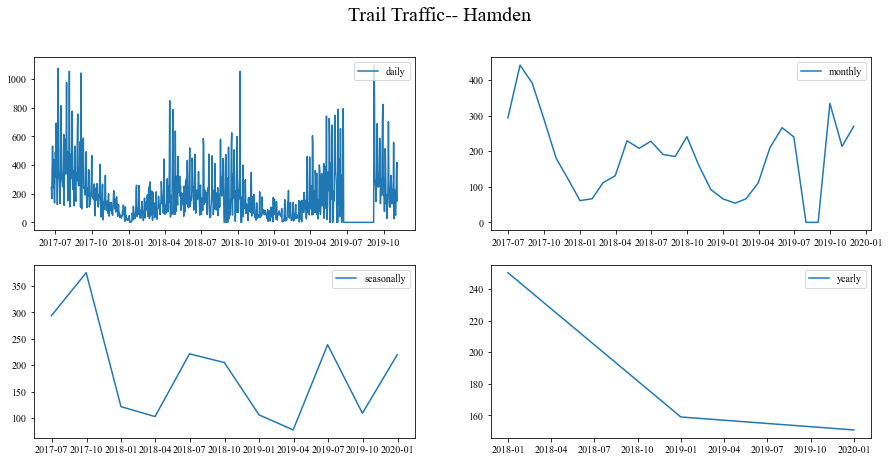

In [12]:
# show trend
fig = plt.figure(figsize=[15,7])
plt.rcParams['font.sans-serif']=['Times New Roman']  
plt.suptitle('Trail Traffic-- Hamden',fontsize=20)
plt.subplot(221)
plt.plot(df.Hamden,'-',label='daily')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Hamden,'-',label='monthly')
plt.legend()
plt.subplot(223)
plt.plot(df_q.Hamden,'-',label='seasonally')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Hamden,'-',label='yearly')
plt.legend()
plt.show()


In [17]:
# set ps q parameter ranges
ps = range(0,3)
qs = range(0,3)
parameters = product(ps,qs)
parameters_list = list(parameters)
# seeking for optimal ARMA parameters (smallest best_aic)
results=[]
best_aic =float("inf")  # infinite
for param in parameters_list:
    try:
        model = ARMA(df_month.Hamden, order=(param[0],param[1])).fit()
    except ValueError:
        print('wrong parameters:',param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param =param
    results.append([param,model.aic])
# print the best results
print('Optimal model:', best_model.summary())


wrong parameters: (0, 2)
Optimal model:                               ARMA Model Results                              
Dep. Variable:                 Hamden   No. Observations:                   30
Model:                     ARMA(0, 1)   Log Likelihood                -175.452
Method:                       css-mle   S.D. of innovations             79.219
Date:                Sun, 20 Sep 2020   AIC                            356.903
Time:                        10:27:47   BIC                            361.107
Sample:                    06-30-2017   HQIC                           358.248
                         - 11-30-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          187.2162     28.471      6.576      0.000     131.414     243.018
ma.L1.Hamden     1.0000      0.124      8.053      0.000       0.757       1.243
    

In [18]:
# set future_month and date_list for forecasting
df_month2 = df_month[['Hamden']]
future_month =12
last_month =pd.to_datetime(df_month2.index[len(df_month2)-1])
print(last_month)

2019-11-30 00:00:00


In [19]:
date_list = []
for i in range(future_month):
    # calculate how many days in the next month
    year = last_month.year
    month = last_month.month
    if month ==12:
        month =1
        year =year+1
    else:
        month=month+1
    next_month_days = calendar.monthrange(year,month)[1]
    print(next_month_days)
    last_month =last_month +timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=',date_list)

31
31
29
31
30
31
30
31
31
30
31
30
date_list= [Timestamp('2019-12-31 00:00:00', freq='M'), Timestamp('2020-01-31 00:00:00', freq='M'), Timestamp('2020-02-29 00:00:00', freq='M'), Timestamp('2020-03-31 00:00:00', freq='M'), Timestamp('2020-04-30 00:00:00', freq='M'), Timestamp('2020-05-31 00:00:00', freq='M'), Timestamp('2020-06-30 00:00:00', freq='M'), Timestamp('2020-07-31 00:00:00', freq='M'), Timestamp('2020-08-31 00:00:00', freq='M'), Timestamp('2020-09-30 00:00:00', freq='M'), Timestamp('2020-10-31 00:00:00', freq='M'), Timestamp('2020-11-30 00:00:00', freq='M')]


In [20]:
# edit the forecasting period
future = pd.DataFrame(index=date_list,columns=df_month.columns)
df_month2 =pd.concat([df_month2,future])
df_month2['forecast'] =best_model.predict(start=0,end=len(df_month2))

# the first element is wrong, set as NaN
df_month2['forecast'][0] =np.NaN
print(df_month2)

                Hamden    forecast
2017-06-30  293.555556         NaN
2017-07-31  441.451613  240.385879
2017-08-31  391.064516  321.260025
2017-09-30  289.933333  239.569571
2017-10-31  180.483871  227.507213
2017-11-30  122.766667  148.030085
2017-12-31   61.064516  165.561844
2018-01-31   66.322581   95.781040
2018-02-28  111.500000  161.030905
2018-03-31  130.967742  142.638388
2018-04-30  228.933333  176.606524
2018-05-31  207.967742  235.182444
2018-06-30  227.933333  162.094939
2018-07-31  190.806452  248.351855
2018-08-31  184.838710  133.507160
2018-09-30  240.500000  235.339531
2018-10-31  158.548387  192.073115
2018-11-30   92.366667  155.553960
2018-12-31   66.032258  127.354557
2019-01-31   53.935484  128.960019
2019-02-28   66.250000  115.764265
2019-03-31  110.774194  139.952587
2019-04-30  209.666667  159.306436
2019-05-31  265.870968  235.478091
2019-06-30  239.733333  216.393365
2019-07-31    0.000000  209.658480
2019-08-31    0.000000  -14.677149
2019-09-30  334.0666

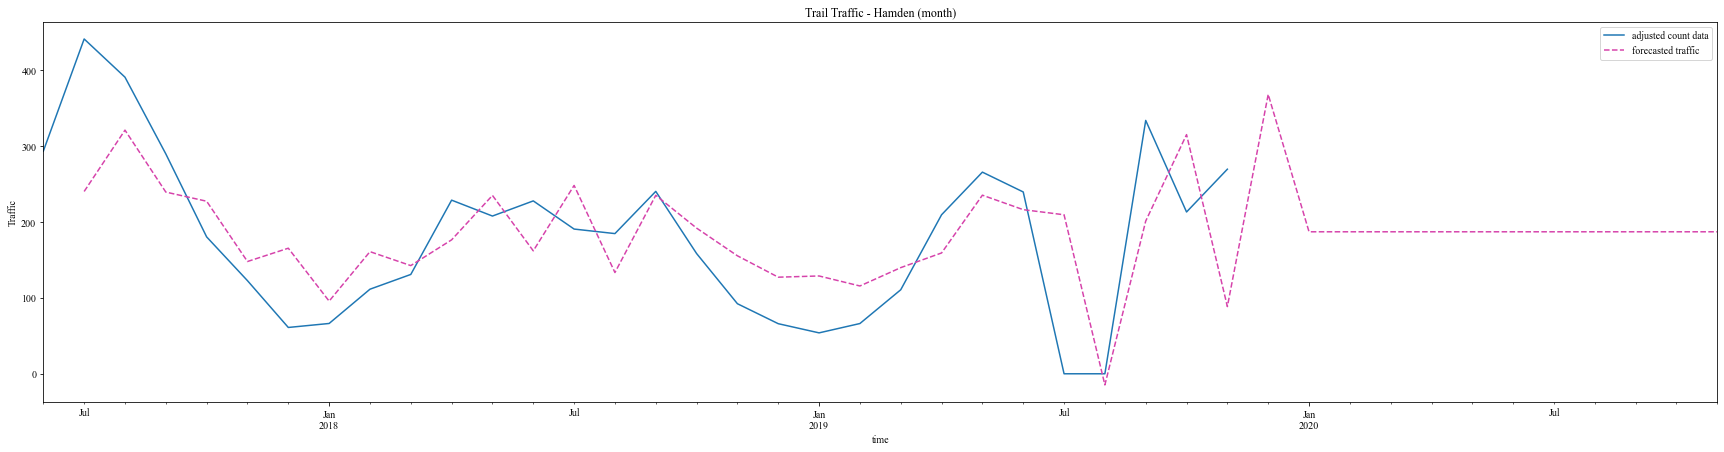

In [22]:
# show predictions
plt.figure(figsize=(30,7))
df_month2.Hamden.plot(label='adjusted count data')
df_month2.forecast.plot(color='#d643ab',ls='--',label='forecasted traffic')
plt.legend()
plt.title('Trail Traffic - Hamden (month)')
plt.xlabel('time')
plt.ylabel('Traffic')
plt.show()